<a href="https://colab.research.google.com/github/Fernando-Fernandez/ApexTriggers/blob/master/CVDB_with_DuckDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

As a thought experiment, we thought we would see how easy or difficult it will be to take the [Open CVDB](https://github.com/wiz-sec/open-cvdb) files and load them into DuckDB to do some quick analysis. The source files are a series of YAML files ([located here](https://github.com/wiz-sec/open-cvdb/tree/main/vulnerabilities)) that we need to shoehorn into the database.

Spoiler alert, turns out it's pretty easy.

# Setup

This uses PyYAML, but it's already installed with Colab.

This uses DuckDB, but it's already installed with Colab.


In [ ]:
# Fetch the files.

!rm -rf /my_computer
!git clone https://github.com/wiz-sec/open-cvdb.git /my_computer
!mkdir  /my_computer/vulnerabilities_json/

Cloning into '/my_computer'...
remote: Enumerating objects: 2358, done.
remote: Counting objects: 100% (319/319), done.
remote: Compressing objects: 100% (242/242), done.
remote: Total 2358 (delta 148), reused 217 (delta 74), pack-reused 2039
Receiving objects: 100% (2358/2358), 35.29 MiB | 35.96 MiB/s, done.
Resolving deltas: 100% (1403/1403), done.


In [ ]:
# Hit the library.

import yaml
import json
import os
from google.colab import data_table

data_table.enable_dataframe_formatter()

Let's process the files and convert them to JSON.

In [ ]:
# Iterate through the YAML files, read them into a native Python data type, and write out JSON.

for filename in os.listdir('/my_computer/vulnerabilities/'):
  filename_yaml = "/my_computer/vulnerabilities/" + filename
  print("Starting: ", filename)
  filename_json = "/my_computer/vulnerabilities_json/" + filename.replace("yaml", "json")
  with open(filename_yaml, 'r') as yaml_in, open(filename_json, "w") as json_out:
    yaml_object = yaml.safe_load(yaml_in) # yaml_object will be a list or a dict
    json.dump(yaml_object, json_out)
  print("Wrote: ", filename_json)

Starting:  gke-autopilot-allowlist.yaml
Wrote:  /my_computer/vulnerabilities_json/gke-autopilot-allowlist.json
Starting:  privilege-identification-cloudtrail.yaml
Wrote:  /my_computer/vulnerabilities_json/privilege-identification-cloudtrail.json
Starting:  aws-xss-console.yaml
Wrote:  /my_computer/vulnerabilities_json/aws-xss-console.json
Starting:  aws-rds-no-ssl-tls.yaml
Wrote:  /my_computer/vulnerabilities_json/aws-rds-no-ssl-tls.json
Starting:  api-mgmt-ssrf-path-traversal.yaml
Wrote:  /my_computer/vulnerabilities_json/api-mgmt-ssrf-path-traversal.json
Starting:  cap-net-raw-metadata-mitm.yaml
Wrote:  /my_computer/vulnerabilities_json/cap-net-raw-metadata-mitm.json
Starting:  aws-fall-2020-soc2.yaml
Wrote:  /my_computer/vulnerabilities_json/aws-fall-2020-soc2.json
Starting:  iam-policies-bypass-overprivileged.yaml
Wrote:  /my_computer/vulnerabilities_json/iam-policies-bypass-overprivileged.json
Starting:  aws-waf-sql-injection.yaml
Wrote:  /my_computer/vulnerabilities_json/aws-waf-

# DuckDB Time!

Let's first take a look at a file and see what they look like.

In [ ]:
!cat /my_computer/vulnerabilities/autowarp.yaml

title: AutoWarp
slug: autowarp
cves: null
affectedPlatforms:
- Azure
affectedServices:
- Automation Service
image: https://images.unsplash.com/photo-1651491602333-fea83f1d9107?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=1170&q=80
severity: Critical
piercingIndexVector: {version: 1.5, A1: 20, A2: 1.21, A7: 1.1, A8: 1.1}
discoveredBy:
  name: Yanir Tsarimi
  org: Orca Security
  domain: https://orca.security/
  twitter: null
publishedAt: 2022/03/07
disclosedAt: 2021/12/06
exploitabilityPeriod: null
knownITWExploitation: false
summary: |
  An exposed endpoint in the Azure Automation Service allowed to steal Azure
  API credentials from other customers
manualRemediation: |
  None required. As a general practice, use the least-privilege
  principle, including on managed identities assigned to automation accounts. While
  this would not have prevented the leakage of API credentials, it would have reduced
  the blast radius.
detectionMethods: null
c

## Let's fetch a duck!

## Create and load table

Load up a DuckDB instance, and start digging.

We are manually defining a schema because while the structure is consistent, the data values are necessarily not. As an example, there are instances where the `knownITWExploitation` field is set to a `STRING` of "No" and others where it's a `BOOL` of `false`. The auto detect functions would set this as a `BOOL` and error out when it hit strings. There are other data types like that as well.

In [ ]:
import duckdb
conn = duckdb.connect()

conn.execute("""
CREATE OR REPLACE TABLE vulns AS (
  SELECT * FROM READ_JSON_AUTO('/my_computer/vulnerabilities_json/*.json', columns={
    title:  'VARCHAR',
    slug:   'VARCHAR',
    cves:   'VARCHAR[]',
    affectedPlatforms:  'VARCHAR[]',
    affectedServices:   'VARCHAR[]',
    image:  'VARCHAR',
    severity:           'VARCHAR',
    discoveredBy:       'STRUCT(name VARCHAR, org VARCHAR, domain VARCHAR, twitter JSON)',
    disclosedAt:        'DATE',
    publishedAt:        'DATE',
    exploitabilityPeriod:   'JSON',
    knownITWExploitation:   'VARCHAR',
    summary:            'VARCHAR',
    manualRemediation:  'VARCHAR',
    detectionMethods:   'JSON',
    contributor:        'VARCHAR',
    "references":       'VARCHAR[]',
    piercingIndexVector:  'STRUCT(version DOUBLE, A1 BIGINT, A2 DOUBLE, A7 DOUBLE, A8 DOUBLE)'
    }, ignore_errors=true
                        ));
""")

conn.execute("""
DESCRIBE vulns;
""").fetchdf()

,column_name,column_type,null,key,default,extra
0,title,VARCHAR,YES,NaN,NaN,NaN
1,slug,VARCHAR,YES,NaN,NaN,NaN
2,cves,VARCHAR[],YES,NaN,NaN,NaN
3,affectedPlatforms,VARCHAR[],YES,NaN,NaN,NaN
4,affectedServices,VARCHAR[],YES,NaN,NaN,NaN
5,image,VARCHAR,YES,NaN,NaN,NaN
6,severity,VARCHAR,YES,NaN,NaN,NaN
7,discoveredBy,"STRUCT(""name"" VARCHAR, org VARCHAR, ""domain"" V...",YES,NaN,NaN,NaN
8,disclosedAt,DATE,YES,NaN,NaN,NaN
9,publishedAt,DATE,YES,NaN,NaN,NaN


## Verify

In [ ]:
# Let's see the data.

conn.execute("SELECT * FROM vulns LIMIT 3").fetchdf()

,title,slug,cves,affectedPlatforms,affectedServices,image,severity,discoveredBy,disclosedAt,publishedAt,exploitabilityPeriod,knownITWExploitation,summary,manualRemediation,detectionMethods,contributor,references,piercingIndexVector
0,AWS uploaded sensitive data to public GitHub b...,aws-data-post,NaN,[AWS],NaN,https://images.unsplash.com/photo-158963038814...,NaN,"{'name': None, 'org': 'Upguard', 'domain': 'ht...",2020-01-23,2020-01-23,NaN,NaN,An AWS employee pushed sensitive data to a pub...,None required\n,NaN,https://github.com/0xdabbad00,[https://www.upguard.com/breaches/identity-and...,NaN
1,Dataflow RCE via unauthenticated JMX service,dataflow-rce-jmx,NaN,[GCP],[Dataflow],https://raw.githubusercontent.com/wiz-sec/open...,Low,"{'name': 'Mike Brancato', 'org': None, 'domain...",2021-03-05,2021-12-28,NaN,false,Dataflow worker nodes ran an unauthenticated J...,None required\n,NaN,https://github.com/korniko98,[https://mbrancato.github.io/2021/12/28/rce-da...,NaN
2,Overprivileged CodeBuild default ECR IAM policy,aws-codebuild-ecr-iam-vuln,NaN,[AWS],"[AWS CodeBuild, AWS ECR]",https://raw.githubusercontent.com/wiz-sec/open...,medium,"{'name': 'Will Deane', 'org': 'ASX Consulting'...",2022-07-04,2023-02-25,"""Until July 26, 2022""",NaN,"For AWS CodeBuild, when using a custom contain...",For any CodeBuild projects created before July...,NaN,https://github.com/willdeane,[https://www.asxconsulting.co.uk/blog/codebuild/],"{'version': 1.5, 'A1': None, 'A2': None, 'A7':..."


In [ ]:
# Quick verification to see if the previous YAML (autowarp) we looked at matches.

conn.execute("""
SELECT * FROM vulns
WHERE title = 'AutoWarp';
""").fetchdf()

,title,slug,cves,affectedPlatforms,affectedServices,image,severity,discoveredBy,disclosedAt,publishedAt,exploitabilityPeriod,knownITWExploitation,summary,manualRemediation,detectionMethods,contributor,references,piercingIndexVector
0,AutoWarp,autowarp,NaN,[Azure],[Automation Service],https://images.unsplash.com/photo-165149160233...,Critical,"{'name': 'Yanir Tsarimi', 'org': 'Orca Securit...",2021-12-06,2022-03-07,NaN,false,An exposed endpoint in the Azure Automation Se...,"None required. As a general practice, use the ...",NaN,https://github.com/christophetd,[https://orca.security/resources/blog/autowarp...,"{'version': 1.5, 'A1': 20, 'A2': 1.21, 'A7': 1..."


# Analysis Time!

It looks like it works! Let's ask some questions.



## How many vulnerabilities were disclosed per month?

<Axes: xlabel='month'>

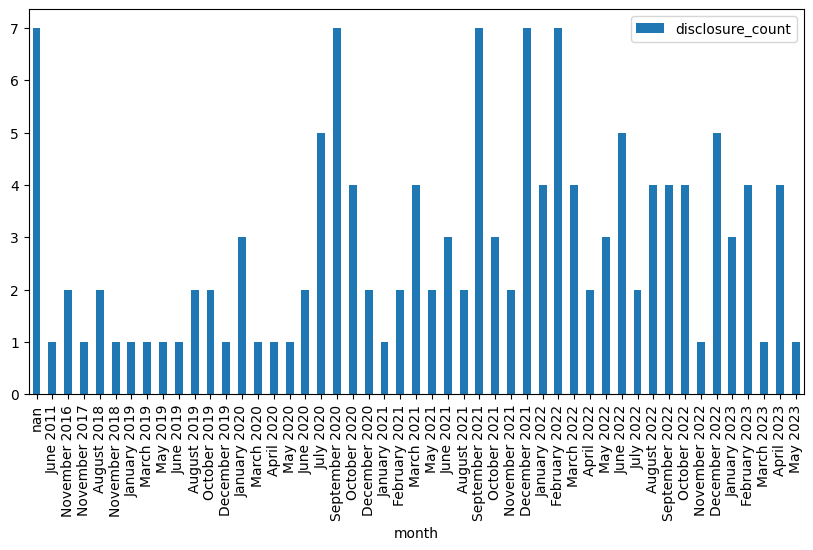

In [ ]:
# How many vulnerabilities were disclosed per month?

results=conn.execute("""
SELECT
  count(*) AS disclosure_count,
  STRFTIME(DATE_TRUNC('month',disclosedAt),'%B %Y') AS month,
  DATE_TRUNC('month', disclosedAt) AS month_datetime
  FROM vulns
  GROUP BY month_datetime
  ORDER BY month_datetime asc;
""").fetchdf()

results.plot(x="month", y="disclosure_count", kind="bar", figsize=(10, 5))

## Are there really disclosures with no disclosure times?

At the time of writing, we are finding that there are entires of `nan` on our histogram. Which makes us wonder, are there really disclosures that don't have time associated with them?

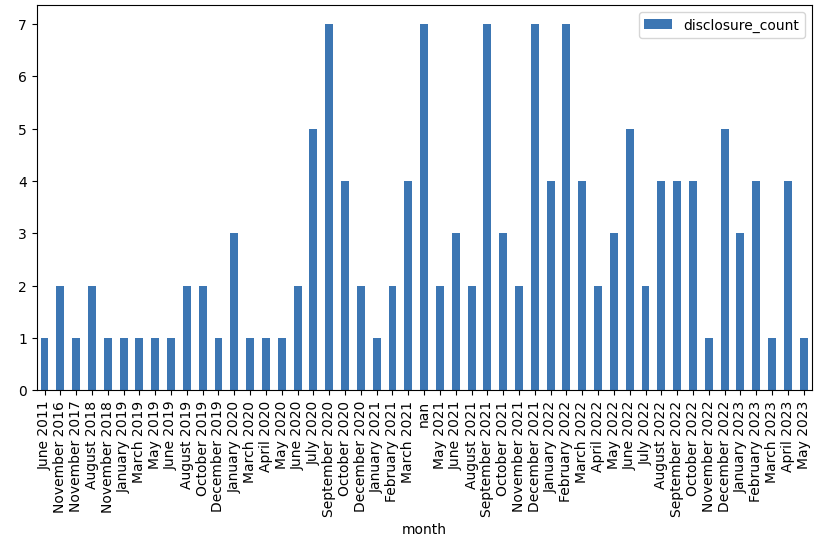

Let's see what the data actually looks like.

In [ ]:
conn.execute("SELECT * FROM vulns WHERE disclosedat IS NULL").fetchdf()

,title,slug,cves,affectedPlatforms,affectedServices,image,severity,discoveredBy,disclosedAt,publishedAt,exploitabilityPeriod,knownITWExploitation,summary,manualRemediation,detectionMethods,contributor,references,piercingIndexVector
0,Signature version 1 (SigV1) is insecure,aws-sigv1-insecure,NaN,[AWS],NaN,https://c4.wallpaperflare.com/wallpaper/600/33...,Medium,"{'name': 'Colin Percival', 'org': None, 'domai...",NaT,2008-12-18,"""until December 18th, 2008""",false,"When making authenticated API requests to AWS,...","None required, SigV1 is deprecated at this poi...",NaN,https://github.com/ramimac,[http://www.daemonology.net/blog/2008-12-18-AW...,NaN
1,AWS Java SDK XXE injection,aws-java-sdk-xxe,NaN,[AWS],[Java SDK],https://raw.githubusercontent.com/wiz-sec/open...,Low,"{'name': 'Alex Brasetvik', 'org': None, 'domai...",NaT,2017-10-10,NaN,false,The AWS Java SDK was vulnerable to XML externa...,None required\n,NaN,https://github.com/korniko98,[https://github.com/aws/aws-sdk-java/commit/08...,NaN
2,GCP Default compute account is project Editor,gcp-default-compute-account,NaN,[GCP],NaN,https://assets.website-files.com/6207f5adfd8e6...,Medium,NaN,NaT,2020-11-22,"""Since the creation of GCP""",false,When the compute API is enabled on a GCP Proje...,"Remove these permissions, it can be done via a...",NaN,https://github.com/louisdurufle,[https://cloud.google.com/resource-manager/doc...,NaN
3,Azure App Service on Azure Stack Hub privilege...,cve-2023-21777,NaN,[Azure],[Azure App Service on Azure Stack Hub],https://raw.githubusercontent.com/wiz-sec/open...,Medium,"{'name': 'Ruslan Sayfiev, Denis Faiustov', 'or...",NaT,2023-02-14,NaN,false,A privilege escalation vulnerability was disco...,Users of Azure App Service on Azure Stack Hub ...,NaN,https://github.com/mer-b,[https://msrc.microsoft.com/update-guide/en-US...,NaN
4,GCP Cloudshell XSS and CSRF bugs,gcp-cloudshell-xss-csrf,NaN,[GCP],[GCP Cloudshell],https://raw.githubusercontent.com/wiz-sec/open...,Medium,"{'name': 'Obmi', 'org': None, 'domain': 'https...",NaT,2019-12-15,NaN,false,GCP Cloudshell has been affected by various XS...,null\n,NaN,https://github.com/mer-b,[https://obmiblog.blogspot.com/2022/12/gcp-202...,NaN
5,SSRF in Google Cloud Monitoring,ssrf-in-google-cloud-monitoring,NaN,[GCP],[Google Cloud Monitoring],https://images.unsplash.com/photo-159085602982...,Medium,"{'name': 'David Nechuta', 'org': None, 'domain...",NaT,2020-11-12,NaN,NaN,An SSRF bug in Google Cloud Monitoring's uptim...,None required\n,NaN,https://github.com/0xdabbad00,[https://nechudav.blogspot.com/2020/11/31k-ssr...,NaN
6,Bad.Build,badbuild,NaN,[GCP],[Cloud Build],https://raw.githubusercontent.com/wiz-sec/open...,Low,"{'name': 'Roi Nisimi', 'org': 'Orca Security',...",NaT,2023-07-18,NaN,false,An information disclosure vulnerability in the...,None required\n,NaN,https://github.com/korniko98,[https://cloud.google.com/build/docs/security-...,NaN


Here we find that there are indeed instances where that is the case. On a side note, we also see that the `exploitabilityPeriod` field is also very much free form, which can make analysis of it somewhat of a challenge.

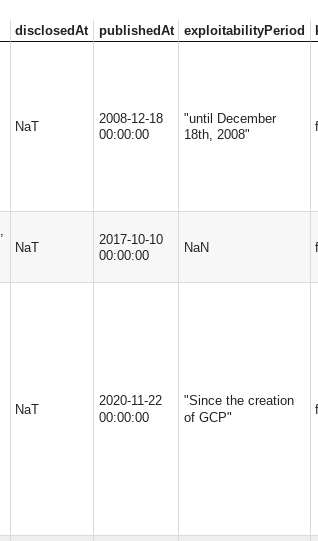

## How many vulnerabilities were published per month?

After chatting with a friend who knows security things more than I do, it looks like the publish date is going to be the one we really want to look at, and the data itself should be more complete. Let's try this one.

<Axes: xlabel='month'>

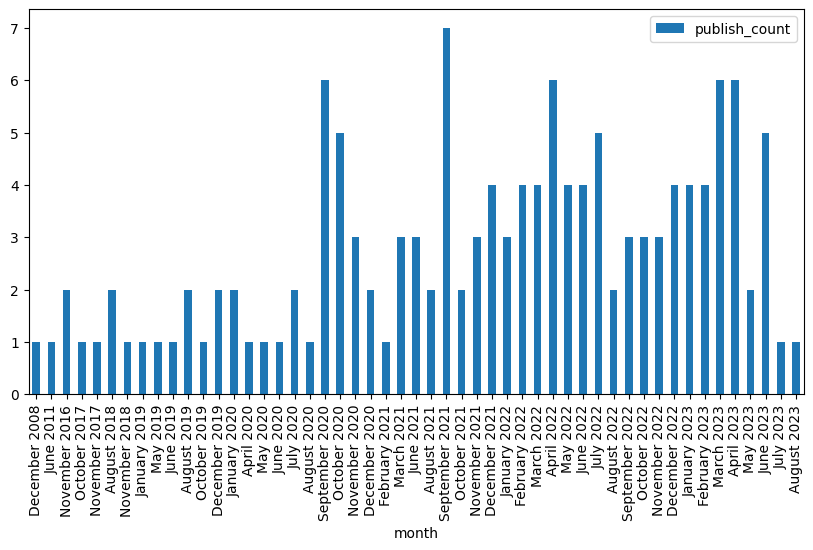

In [ ]:
# How many vulnerabilities were published per month?

results=conn.execute("""
SELECT
  count(*) AS publish_count,
  STRFTIME(DATE_TRUNC('month',publishedAt),'%B %Y') AS month,
  DATE_TRUNC('month', publishedAt) AS month_datetime
  FROM vulns
  GROUP BY month_datetime
  ORDER BY month_datetime asc;
""").fetchdf()

results.plot(x="month", y="publish_count", kind="bar", figsize=(10, 5))

## What cloud platforms have the most vulnerabilities?

<Axes: ylabel='count'>

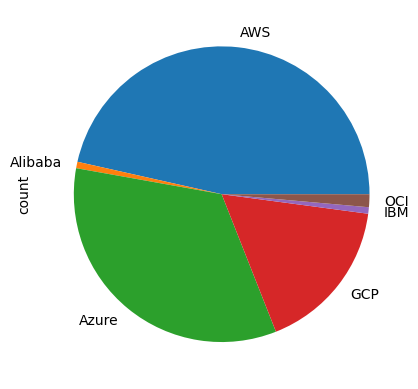

In [ ]:
results=conn.execute("""
  WITH unnested_platforms AS (
    SELECT UNNEST(affectedPlatforms) AS cloud_platform
    FROM vulns)
  SELECT count(*) AS count, cloud_platform FROM unnested_platforms
  GROUP BY cloud_platform
""").fetchdf()

results.groupby(['cloud_platform']).sum().plot.pie(y="count", legend=None)

## What services have the most vulnerabilities?

Let's do the same thing with the services.

<Axes: xlabel='services'>

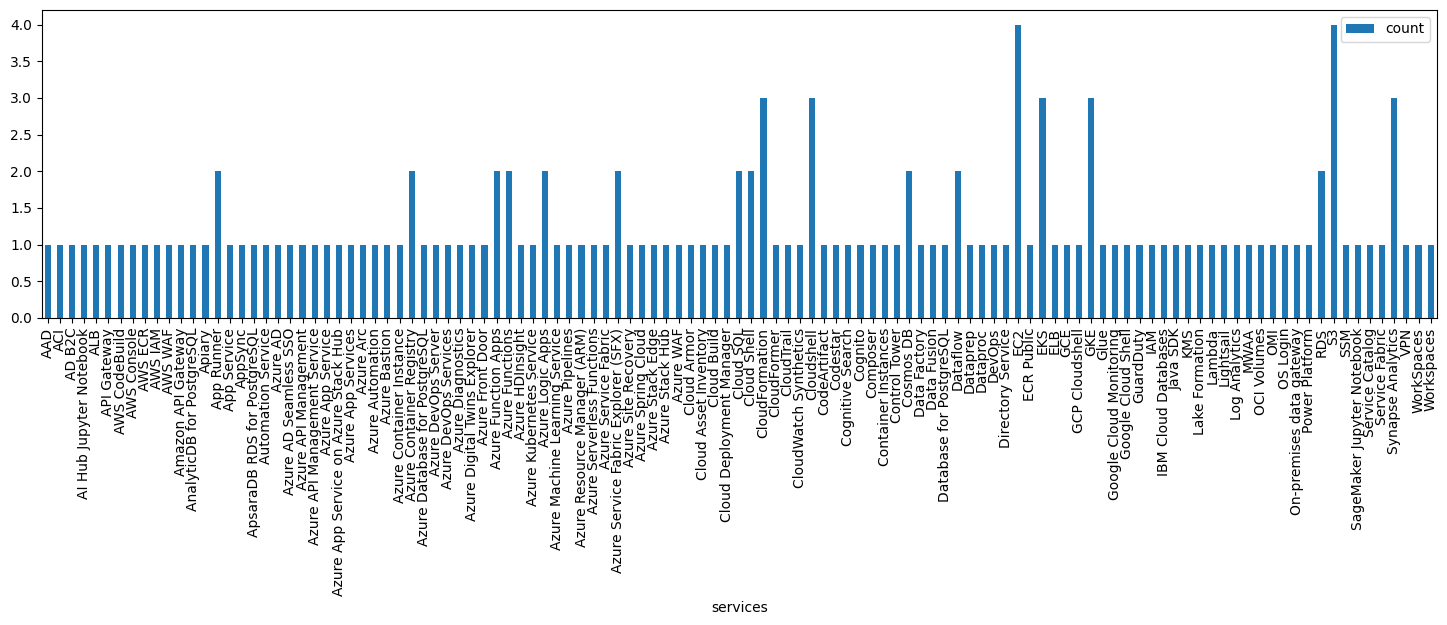

In [ ]:
results=conn.execute("""
  WITH unnested_services AS (
    SELECT UNNEST(affectedServices) AS services
    FROM vulns)
  SELECT count(*) AS count, services FROM unnested_services
  GROUP BY services
  ORDER BY services ASC
""").fetchdf()

results.groupby(['services']).sum().plot.bar(y="count", figsize=(18, 4))